In [1]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2,fnmatch

slim = tf.contrib.slim

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import sys
sys.path.append('/Users/Jyothiraditya/Desktop/ssd/SSD-Tensorflow')
#sys.path

In [4]:
from nets import ssd_vgg_300, ssd_common, np_methods, visua
from preprocessing import ssd_vgg_preprocessing
#from visua import visua

In [5]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

In [6]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [7]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

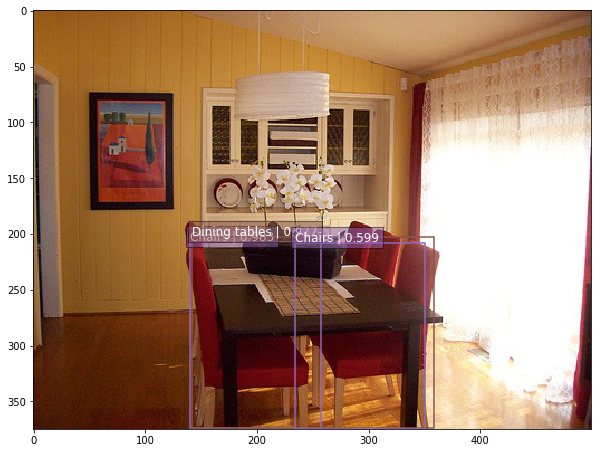

In [ ]:
# Test on some demo image and visualize output.
path = '../demo/'
image_names = sorted(os.listdir(path))

img = mpimg.imread(path + image_names[8])
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visua.plt_bboxes(img, rclasses, rscores, rbboxes)

In [ ]:
inputpath = '/Users/Jyothiraditya/Documents/test1/'
outputpath = '/Users/Jyothiraditya/Documents/test/'
for f in fnmatch.filter(os.listdir(inputpath), '*.jpg'):
    img = mpimg.imread(inputpath + f)
    rclasses, rscores, rbboxes =  process_image(img)

    # visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
    visua.plt_bboxes_save(img, rclasses, rscores, rbboxes,outputpath,f)
    print f

frame189.jpg
frame190.jpg
frame191.jpg
frame192.jpg
frame193.jpg
frame194.jpg
frame195.jpg
frame196.jpg
frame197.jpg
frame198.jpg
frame199.jpg
frame200.jpg
frame201.jpg
frame202.jpg
frame203.jpg
frame204.jpg
frame205.jpg
frame206.jpg
frame207.jpg
frame208.jpg
frame209.jpg
frame210.jpg
frame211.jpg
frame212.jpg
frame213.jpg
frame214.jpg
frame215.jpg
frame216.jpg
frame217.jpg
frame218.jpg
frame219.jpg
frame220.jpg
frame221.jpg
frame222.jpg
frame223.jpg
frame224.jpg
frame225.jpg
frame226.jpg
frame227.jpg
frame228.jpg
frame229.jpg
frame230.jpg
frame231.jpg
frame232.jpg
frame233.jpg
frame234.jpg
frame235.jpg
frame236.jpg
frame237.jpg
frame238.jpg
frame239.jpg
frame240.jpg
frame241.jpg
frame242.jpg
frame243.jpg
frame244.jpg
frame245.jpg
frame246.jpg
frame247.jpg
frame248.jpg
frame249.jpg
frame250.jpg
frame251.jpg
frame252.jpg
frame253.jpg
frame254.jpg
frame255.jpg
frame256.jpg
frame257.jpg
frame258.jpg
frame259.jpg
frame260.jpg
frame261.jpg
frame262.jpg
frame263.jpg
frame264.jpg
frame265.jpg

In [ ]:
## Video Analysis
def frames_to_video(inputpath,outputpath,fps):
   image_array = []
   files = []
   #print len(fnmatch.filter(os.listdir(inputpath), '*.jpg')), os.listdir(inputpath)
   for f in fnmatch.filter(os.listdir(inputpath), '*.jpg'):
      files.append(f)

   #print files
   for i in range(len(files)):
       img = cv2.imread(inputpath + files[i])
       size =  (img.shape[1],img.shape[0])
       img = cv2.resize(img,size)
       image_array.append(img)
   fourcc = cv2.VideoWriter_fourcc('D', 'I', 'V', 'X')
   out = cv2.VideoWriter(outputpath,fourcc, fps, size)
   for i in range(len(image_array)):
       out.write(image_array[i])
   out.release()